In [52]:
%matplotlib inline
from utils2 import *
import matplotlib.pyplot as plt
#from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm
from keras.optimizers import Adam

image_size = (256,256) #(512,512) (720, 1280)
bs = 2

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}

backbone = 'mobilenetv2' #mobilenetv2, xception

NET = 'deeplab_' + backbone
    
PATH = 'C:/Users/jgolb/Desktop/datasets/'

n_classes = len(get_VOC2012_classes()) - 1

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)
print('Batch size:', bs)


SegClass = SegModel(PATH, image_size)
SegClass.set_batch_size(bs)

Num workers: 4
Backbone: mobilenetv2
Path to dataset: C:/Users/jgolb/Desktop/datasets/
N classes: 21
Image size: (256, 256)
Batch size: 2


## DeepLab V3+ And a SubPixel Upsampling Layer

In [5]:
model = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=True, multi_gpu=False, backbone=backbone)
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
print('Weights path:', SegClass.modelpath)

Weights path: weights/subpixel{epoch:03d}.h5


## Original DeepLab v3+

In [3]:
model = SegClass.create_seg_model(net='original',n=n_classes, load_weights=True, multi_gpu=False)
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
print('Weights path:', SegClass.modelpath)

Weights path: weights/original{epoch:03d}.h5


### Train with generator

In [6]:
train_generator = SegClass.create_generators(blur = 5,crop_shape = None, mode = 'train', n_classes = n_classes,
                                             horizontal_flip = True, vertical_flip = False, brightness=0.3, 
                                             rotation=False, zoom=0.1, validation_split = .15, seed = 7, do_ahisteq = False)
valid_generator = SegClass.create_generators(blur = 0, crop_shape = None, mode = 'validation', 
                                             n_classes = n_classes, horizontal_flip = True, vertical_flip = False, 
                                             brightness=.1, rotation=False, zoom=.05, validation_split = .15, 
                                             seed = 7, do_ahisteq = False)

In [ ]:
monitor = 'pred_mask_Jaccard'
mode = 'max'

# fine-tune model (train only last conv layers)
flag = 0
for k, l in enumerate(model.layers):
    l.trainable = False
    if l.name == 'concat_projection':
        flag = 1
    if flag:
        l.trainable = True
        
def build_callbacks(tf_board = False):
    tensorboard = TensorBoard(log_dir='./logs/'+SegClass.net, histogram_freq=0,
                        write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = SegClass.modelpath, verbose=1, save_best_only=True, save_weights_only=True,
                                    monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,
                patience=5, min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = False)
        
SegClass.set_num_epochs(1)
history = SegClass.train_generator(model, train_generator, valid_generator, callbacks, mp = True)

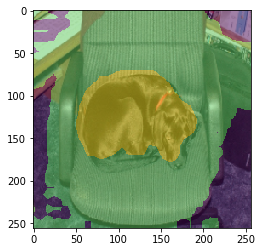

In [39]:
i = np.random.randint(0, len(valid_generator))
x,y,s = valid_generator.__getitem__(i)
preds = np.argmax(model.predict(x), -1)

plt.imshow(x[0].astype('uint8'))
plt.imshow(preds[0].reshape(image_size), alpha=.5)

In [104]:
def calculate_iou(nb_classes = 21):
    SegClass.set_batch_size(1)
    valid_generator = SegClass.create_generators(crop_shape = None,mode = 'validation', n_classes = nb_classes, 
                                                 horizontal_flip = False, vertical_flip = False,
                                                 brightness=0, rotation=False,
                                                 zoom=0, validation_split = .05, seed = 7, do_ahisteq = False)
    label = np.zeros((len(valid_generator),np.prod(image_size)), dtype='float32')
    X = np.zeros((len(valid_generator), image_size[0], image_size[1], 3), dtype='float32')
    for n in tqdm(range(len(valid_generator))):
        x,y,_ = valid_generator.__getitem__(n)
        label[n,:] = y[0,:,0]
        X[n,:,:,:] = x
    preds = model.predict(X, batch_size=1)
    conf_m = np.zeros((nb_classes, nb_classes), dtype=float)
    total = 0
    mask = np.reshape(np.argmax(preds, axis=-1), (-1,) + image_size)
    flat_pred = np.ravel(mask).astype('int')
    flat_label = np.ravel(label).astype('int')
    for p, l in zip(flat_pred, flat_label):
        if l == nb_classes:
            continue
        if l < nb_classes and p < nb_classes:
            conf_m[l-1, p-1] += 1
        else:
            print('Invalid entry encountered, skipping! Label: ', l,
                    ' Prediction: ', p, ' Img_num: ', img_num)
    I = np.diag(conf_m)
    U = np.sum(conf_m, axis=0) + np.sum(conf_m, axis=1) - I
    IOU = I/U
    meanIOU = np.mean(IOU)
    return conf_m, IOU, meanIOU
conf_m, IOU, meanIOU = calculate_iou(nb_classes = 21)

100%|████████████████████████████████████████████████████████████████████████████████| 601/601 [00:12<00:00, 48.70it/s]


601/601 [==============================] - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 55 - ETA: 53 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 3

In [119]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    trained_classes = classes
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=11)
    tick_marks = np.arange(len(classes))
    plt.xticks(np.arange(len(trained_classes)), classes, rotation=90,fontsize=9)
    plt.yticks(tick_marks, classes,fontsize=9)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=7)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=9)
    plt.xlabel('Predicted label',fontsize=9)
    plt.colorbar()

Text(0.5,1,'Mean IOU: 0.5978623398154413')

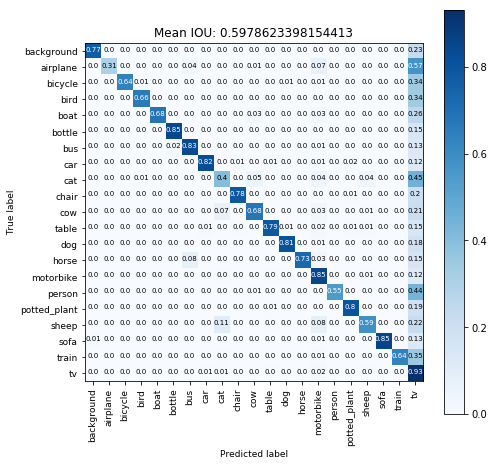

In [120]:
classes = [c for c in get_VOC2012_classes().values()][:-1]
plt.figure(figsize=(7,7))
plot_confusion_matrix(conf_m, classes, normalize=True)
plt.title('Mean IOU: '+ str(meanIOU))